In [1]:
# installing necessary packages here
!pip install natsort

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
import numpy as np 
import pandas as pd 
from glob import glob
from skimage.io import imread
import skimage.io as sio
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from skimage.transform import resize, rotate
import warnings; warnings.filterwarnings("ignore")

In [3]:
# train test directories
root_dir = "../input"
train_dir = root_dir + "/train/train/"
test_dir  = root_dir + "/test/test/"
csv_path  = root_dir + "/train.csv"
sub_path  = root_dir + "sample_submission.csv"

# loading images
df   = pd.read_csv(csv_path)
x    = np.array([ imread(train_dir+p) for p in df.id.values])
y    = df.has_cactus.values

In [4]:
# splitting training dataset into train/validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20,stratify=y)

## VISUALIZING CACTUS IMAGES

In [5]:
# helper functions here
def display_images(imgs,y=None, y_pred=None):
    n_images = imgs.shape[0]
    n_gridx  = 5
    n_gridy  = n_images//n_gridx
#     n_grid   = int(np.sqrt(n_images))
    k = 1
    plt.figure(figsize=(10,6),frameon=False)
    for i in range(n_gridy):
        for j in range(n_gridx):
            plt.subplot(n_gridy, n_gridx, k)
            plt.imshow(imgs[k-1])
            plt.axis("off")
            if (y is not None) and (y_pred is not None):
                plt.title("y=%d | pred=%0.1f"%(y[k-1],y_pred[k-1]))
            elif y is not None:
                plt.title("y=%d"%y[k-1])
            k+=1
    plt.tight_layout()
    plt.show()
    
# conv-net block
def conv(x, filters, kernel_size, strides, padding, batchnorm=True, activation="relu"):
    x = tf.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding )(x)
    x = tf.layers.BatchNormalization()(x)
    if activation == "relu":
        x = tf.nn.relu(x)
    if activation == "leakyrelu":
        x = tf.nn.leaky_relu(x, alpha=0.01)
    return x


def augmenter(images, fliplr=True,flipud=True,rot=5,rot_mode='edge',rot90=True):
    aug_images = []
    for image in images:
        aug_img = image
        if fliplr: # randomly fliplr
            if np.random.uniform(low=0, high=1) > 0.5:
                aug_img = np.fliplr(aug_img)
        if flipud: # randomly flipud
            if np.random.uniform(low=0, high=1) > 0.5:
                aug_img = np.flipud(aug_img)
        if rot90: # randomly rotate 90 degrees
            if np.random.uniform(low=0, high=1) > 0.5:
                k = np.random.randint(low=0, high=4)
                aug_img = np.rot90(aug_img, k = k, axes=(0,1))
        if rot != None: # randomly rotate if True
            if np.random.uniform(low=0, high=1) > 0.5:
                angle = np.random.uniform(low=0, high = rot)
                aug_img = rotate(aug_img, angle, mode = rot_mode, preserve_range=True)
        aug_images.append(aug_img)
    return np.array(aug_images)

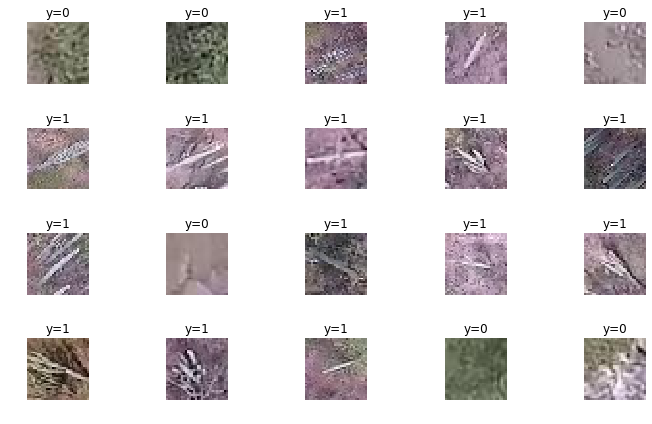

In [6]:
n_samples  = 20
idx_sample = np.random.randint(0,len(x_train),n_samples)
display_images(x_train[idx_sample], y_train[idx_sample])

# ConvNet

In [12]:
x_input = tf.placeholder("float32",shape=(None,32,32,3))
y_label = tf.placeholder("uint8",shape=(None))
y_onehot= tf.one_hot(y_label, depth=2)

# conv-net here
h1 = conv(x_input, filters=16, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h1 = conv(h1,      filters=16, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h1 = tf.layers.MaxPooling2D(pool_size=2,strides=2)(h1)

h2 = conv(h1, filters=32, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h2 = conv(h2, filters=32, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h2 = tf.layers.MaxPooling2D(pool_size=2,strides=2)(h2)

h3 = conv(h2, filters=64, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h3 = conv(h3, filters=64, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h3 = tf.layers.MaxPooling2D(pool_size=2,strides=2)(h3)

h4 = conv(h3, filters=128, kernel_size=3, strides=1, padding="same", batchnorm=True, activation="leakyrelu")
h4 = conv(h4, filters=128, kernel_size=3, strides=1, padding="valid", batchnorm=True, activation="leakyrelu")
h4 = tf.layers.MaxPooling2D(pool_size=2,strides=2)(h4)

h5       = tf.layers.Flatten()(h4)
y_logits = tf.layers.Dense(2)(h5)
y_prob   = tf.nn.softmax(y_logits)
y_pred   = tf.arg_max(y_logits, -1)

In [13]:
# defining losses
hinge_loss = tf.losses.hinge_loss(labels=y_onehot, logits=y_logits, )
ce_loss   = tf.losses.softmax_cross_entropy(y_onehot, y_logits)
total_loss = 0.0*hinge_loss + ce_loss

# defining model optimizer
opt     = tf.train.AdamOptimizer(learning_rate=0.001,).minimize(total_loss)

# starting session and init ops
sess = tf.Session()
global_init = tf.global_variables_initializer()
local_init  = tf.local_variables_initializer()
_ = sess.run([global_init, local_init])

In [16]:
# training here
epochs    = 100
batchsize = 32

n_train   = len(x_train)
n_batches = len(x_train)//batchsize
for e in range(epochs):
    shuffled_idx0 = np.random.permutation(np.where(y_train == 0)[0])
    shuffled_idx1 = np.random.permutation(np.where(y_train == 1)[0])
    run_metrics = {"loss":[],"accuracy":[], "recall":[], "precision":[],"f1":[], "roc":[]}
    print("+-"*15+"\t epoch = %0.3d \t"%e+"-+"*15)
    for i in range(n_batches):
        batch0_idx = np.random.randint(0, len(shuffled_idx0), batchsize//2)
        batch0_idx = shuffled_idx0[batch0_idx]
        batch1_idx = np.random.randint(0, len(shuffled_idx1), batchsize//2)
        batch1_idx = shuffled_idx1[batch1_idx]
        x0_batch   = x_train[batch0_idx]
        x1_batch   = x_train[batch1_idx]
        y0_batch   = y_train[batch0_idx]
        y1_batch   = y_train[batch1_idx]
        x_batch    = np.concatenate([x0_batch, x1_batch])
        x_batch    = augmenter(x_batch)
        y_batch    = np.concatenate([y0_batch, y1_batch])
        _, y_pred_batch, y_prob_batch, loss_batch = sess.run([opt, y_pred, y_prob, total_loss], 
                                                             feed_dict={x_input: x_batch, 
                                                                        y_label: y_batch.reshape(-1,1)})
        acc       = accuracy_score(y_batch, y_pred_batch,)
        prec      = precision_score(y_batch, y_pred_batch)
        rec       = recall_score(y_batch, y_pred_batch)
        f1        = f1_score(y_batch, y_pred_batch)
        roc       = roc_auc_score(y_batch, y_prob_batch[:,1])
        run_metrics["loss"].append(loss_batch)
        run_metrics["accuracy"].append(acc)
        run_metrics["recall"].append(rec)
        run_metrics["precision"].append(prec)
        run_metrics["f1"].append(f1)
        run_metrics["roc"].append(roc)

        print("loss = %0.3f \t acc = %0.3f \t roc = %0.3f \t precision = %0.3f \t recall = %0.3f \t f1 = %0.3f"%
              (np.mean(run_metrics["loss"]),
               np.mean(run_metrics["accuracy"]), 
               np.mean(run_metrics["roc"]), 
               np.mean(run_metrics["precision"]), 
               np.mean(run_metrics["recall"]),
               np.mean(run_metrics["f1"])),end="\r")
    print("train :: loss = %0.3f :: acc = %0.3f :: roc = %0.3f :: precision = %0.3f :: recall = %0.3f :: f1 = %0.3f"%
      (np.mean(run_metrics["loss"]),
       np.mean(run_metrics["accuracy"]), 
       np.mean(run_metrics["roc"]), 
       np.mean(run_metrics["precision"]), 
       np.mean(run_metrics["recall"]),
       np.mean(run_metrics["f1"])))
    # computing validation score
    y_pred_batch, y_prob_batch, loss_batch = sess.run([y_pred,y_prob, total_loss], 
                                                      feed_dict={x_input: x_val, 
                                                                 y_label: y_val.reshape(-1,1)})
    acc       = accuracy_score(y_val, y_pred_batch,)
    prec      = precision_score(y_val, y_pred_batch)
    rec       = recall_score(y_val, y_pred_batch)
    f1        = f1_score(y_val, y_pred_batch)
    roc       = roc_auc_score(y_val, y_prob_batch[:,1])
    print("valid :: loss = %0.3f :: acc = %0.3f :: roc = %0.3f :: precision = %0.3f :: recall = %0.3f :: f1 = %0.3f\n\n"%
          (loss_batch,acc,roc, prec, rec,f1))

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-	 epoch = 000 	-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
train :: loss = 0.049 :: acc = 0.983 :: roc = 0.999 :: precision = 0.986 :: recall = 0.982 :: f1 = 0.983


ValueError: bad input shape (3500, 2)

In [18]:
# saving session
saver = tf.train.Saver()
saver.save(sess, "cactus_net.ckpt")

'cactus_net.ckpt'

# Test Prediction

In [19]:
df_test = pd.read_csv('../input/sample_submission.csv')
x_test  = np.array([ imread(test_dir+p) for p in df_test.id.values])
x_test  = np.array(x_test)

# test prediction
from tqdm import tqdm
batchsize = 32
n_batches = (len(x_test) // batchsize) + batchsize
y_pred_test = []
last_iter = False
for i in tqdm(range(n_batches)):
    start     = i*batchsize
    end       = (i+1)*batchsize
    if end >= len(x_test):
        if last_iter:
            break
        end  = len(x_test)
        last_iter = True    
    y_prob_batch = sess.run([y_prob], feed_dict={x_input: x_test[start:end]})[0]
    y_prob_batch = y_prob_batch[:,1]
    y_pred_test.extend(y_prob_batch)
y_pred_test = np.array(y_pred_test)

df_test['has_cactus'] = y_pred_test
df_test.to_csv('cactus_net_submission.csv', index=False)

 80%|███████▉  | 125/157 [00:04<00:01, 27.44it/s]
